In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from surface_code import create_surface_code_circuit, run_with_errors, plot_ler_vs_p_from_stats
from surface_code import build_spacetime_decoders, decode_counts_spacetime, checks_to_H

/Users/eli/dev/superstabilizer_splicing/.venv/lib/python3.11/site-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


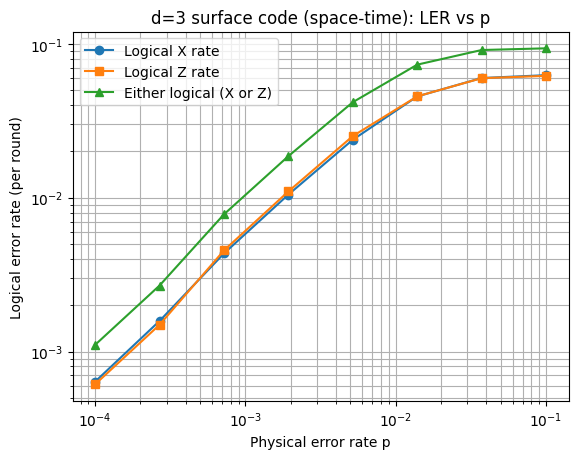

In [22]:
# === Space-time LER vs p sweep & plot ===
# Assumes the functions listed above are already defined in prior cells.

import numpy as np

distance = 3
SHOTS_PER_P = 20000
SEED = 12345
# Physical error sweep (tweak as you like)
PS = np.logspace(-4, -1, 8)  # 1e-4 ... 1e-1

# Logical strings (match your boundary choice from create_surface_code_circuit)
Z_L_support = [1, 4, 7]   # vertical (connects X-boundaries) → used with z-type residual
X_L_support = [3, 4, 5]   # horizontal (connects Z-boundaries) → used with x-type residual

qc, X_checks, Z_checks, n_data, n_rounds = create_surface_code_circuit(distance=distance)
assert n_rounds >= 2, "Space-time decoding needs at least 2 rounds."

dec_Xst, dec_Zst, meta = build_spacetime_decoders(X_checks, Z_checks, n_data, n_rounds)

H_X = checks_to_H(X_checks, n_data)
H_Z = checks_to_H(Z_checks, n_data)

stats_by_p = {}
for p in PS:
    counts = run_with_errors(
        qc,
        p1=p,          # 1q depolarizing rate
        p2=p,          # 2q depolarizing rate (you can try p2=2*p if desired)
        p_meas=p,      # readout flips
        p_reset=p/2,   # reset error
        shots=SHOTS_PER_P,
        seed=SEED,
    )

    # stats = decode_counts_spacetime(
    #     counts=counts,
    #     dec_Xst=dec_Xst, dec_Zst=dec_Zst,
    #     X_checks=X_checks, Z_checks=Z_checks,
    #     n_data=n_data, n_rounds=n_rounds,
    #     X_L_support=X_L_support, Z_L_support=Z_L_support
    # )

    stats = decode_counts_spacetime(
        counts, dec_Xst, dec_Zst,
        X_checks, Z_checks, n_data, n_rounds,
        X_L_support=X_L_support, Z_L_support=Z_L_support,
        H_X=H_X, H_Z=H_Z
    )
    stats_by_p[float(p)] = stats

fig, ax, df = plot_ler_vs_p_from_stats(stats_by_p, title=f"d={distance} surface code (space-time): LER vs p")

In [37]:
print(checks_to_H(X_checks, n_data))

[[1 1 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 1 1]
 [0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0]]


In [44]:
from surface_code import _rref_mod2, reduce_mod_stabilizers, logical_parities_from_residual
import unittest

H_Z = np.array([
    [0, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 1]
], dtype=np.uint8)

# H_X: X-stabilizers (Plaquette/Face operators, checks Z errors).
# [X1 X2 X4 X5], [X5 X6 X8 X9], [X2 X3], [X7 X8]
H_X = np.array([
    [1, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 1, 1],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0]
], dtype=np.uint8)

# Logical Operators (Supports are the indices where Pauli is applied, 0-indexed)
# X_L: Spanning X chain (e.g., qubits 3, 6, 9 - right column: indices 2, 5, 8)
X_L_indices = [2, 5, 8]
# Z_L: Spanning Z chain (Using the Bottom Row, which anti-commutes with X_L)
Z_L_indices = [6, 7, 8]


class SurfaceCodeTests(unittest.TestCase):
    
    def test_rref_mod2_sanity(self):
        # Test 1: Sanity check for RREF on H_Z
        R, pivots = _rref_mod2(H_Z)
        
        # Check rank (should be 4)
        self.assertEqual(len(pivots), 4, "RREF rank should be 4.")
        
        # RREF calculated for the new H_Z matrix (Pivots at columns 0, 1, 3, 5):
        # This corrected array fixes the prior RREF calculation error.
        expected_R_start = np.array([
            [1, 0, 0, 0, 1, 0, 1, 1, 0], # C0 pivot
            [0, 1, 1, 0, 1, 0, 0, 0, 1], # C1 pivot (This row was wrong previously)
            [0, 0, 0, 1, 1, 0, 1, 1, 0], # C3 pivot
            [0, 0, 0, 0, 0, 1, 0, 0, 1]  # C5 pivot
        ], dtype=np.uint8)
        
        # We only check the first 4 rows which contain the non-zero information
        self.assertTrue(np.all(R[:4] == expected_R_start), "RREF matrix is incorrect.")

    def test_reduce_mod_stabilizers_trivial_error(self):
        # Test 2: Input a physical X error that IS a stabilizer (trivial error)
        # Error e = S3 = [1, 0, 0, 1, 0, 0, 0, 0, 0] (row 2)
        e_stabilizer = H_Z[2]
        
        # This error should reduce to the zero vector (e_red = 0)
        e_red = reduce_mod_stabilizers(e_stabilizer, H_Z)
        
        self.assertTrue(np.all(e_red == 0), "Trivial stabilizer error should reduce to [0, 0, ...].")

    def test_reduce_mod_stabilizers_non_canonical_logical_error(self):
        # Test 3: Input a non-canonical X_L logical error (first column: X1 X4 X7)
        
        # X_error on 1, 4, 7 (indices 0, 3, 6)
        # e_non_canonical = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0], dtype=np.uint8) 
        e_non_canonical = np.array([0, 0, 1, 0, 0, 1, 0, 0, 1], dtype=np.uint8)
        
        e_red = reduce_mod_stabilizers(e_non_canonical, H_Z)
        print(e_red)

        # print("===", reduce_mod_stabilizers(np.array([0, 1, 0, 0, 1, 0, 0, 1, 0], dtype=np.uint8), H_Z))
        # print("===", reduce_mod_stabilizers(np.array([0, 0, 1, 0, 0, 1, 0, 0, 1], dtype=np.uint8), H_Z))
        
        # The result must be non-zero (it is a logical error)
        self.assertTrue(np.any(e_red != 0), "Logical error should reduce to a non-zero vector.")
        
        # Let's verify the dot product with the NEW Z_L checker (Bottom Row). It MUST be 1.
        Z_L_vec = np.zeros(9, dtype=np.uint8)
        Z_L_vec[Z_L_indices] = 1 
        
        logical_overlap = np.dot(e_red, Z_L_vec) % 2
        # The reduction of X1 X4 X7 is X7, which anticommutes with Z7 Z8 Z9. Overlap is 1.
        self.assertEqual(logical_overlap, 1, "Non-canonical X_L error should have L_Z parity of 1.")


    def test_logical_parities_full_x_error(self):
        # Test 4: Check full end-to-end detection of a non-canonical X_L error.
        
        # x_residual: X error on 1, 4, 7 (indices 0, 3, 6) - Non-canonical X_L
        x_res = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0], dtype=np.uint8) 
        # z_residual: No Z error
        z_res = np.zeros(9, dtype=np.uint8)
        
        # logical_X should be 0 (no Z_L error detected)
        # logical_Z should be 1 (X_L error detected, flips Z_L state)
        logical_X, logical_Z = logical_parities_from_residual(
            x_res, z_res, H_X, H_Z, X_L_indices, Z_L_indices
        )
        
        self.assertEqual(logical_X, 0, "No Z_L logical error should be detected (logical_X=0).")
        self.assertEqual(logical_Z, 1, "X_L logical error should be detected (logical_Z=1).")
        
    def test_logical_parities_full_z_error(self):
        # Test 5: Check full end-to-end detection of a non-canonical Z_L error.
        
        # x_residual: No X error
        x_res = np.zeros(9, dtype=np.uint8)
        # z_residual: Z error on 4, 5, 6 (indices 3, 4, 5 - middle row Zs) - Non-canonical Z_L
        z_res = np.array([0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=np.uint8) 
        
        # logical_X should be 1 (Z_L error detected, flips X_L state)
        # logical_Z should be 0 (no X_L error detected)
        logical_X, logical_Z = logical_parities_from_residual(
            x_res, z_res, H_X, H_Z, X_L_indices, Z_L_indices
        )
        
        self.assertEqual(logical_X, 1, "Z_L logical error should be detected (logical_X=1).")
        self.assertEqual(logical_Z, 0, "No X_L logical error should be detected (logical_Z=0).")
        
    def test_logical_parities_orthogonal_check(self):
        # Test 6: Check that an X-error chain that is ORTHOGONAL to the L_Z checker 
        # but IS NOT a logical error is correctly classified.
        
        # X-error on X7 X8 (indices 6, 7) - This is a local error, should be trivial after reduction.
        x_res = np.array([0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=np.uint8) 
        z_res = np.zeros(9, dtype=np.uint8)
        
        # X7 X8 commutes with Z7 Z8 Z9 (Bottom Row Z_L) and should reduce to 0.
        # logical_X should be 0
        # logical_Z should be 0
        logical_X, logical_Z = logical_parities_from_residual(
            x_res, z_res, H_X, H_Z, X_L_indices, Z_L_indices
        )
        
        self.assertEqual(logical_X, 0, "Trivial error shouldn't flip X_L (logical_X=0).")
        self.assertEqual(logical_Z, 0, "Trivial error shouldn't flip Z_L (logical_Z=0).")




# You would typically run these tests using the command line: 
# python -m unittest surface_code_tests.py
# But for this environment, we execute them directly.
print("--- Running Surface Code Sanity Checks ---")

# Create a TestSuite and run it
suite = unittest.TestSuite()
suite.addTest(unittest.makeSuite(SurfaceCodeTests))
runner = unittest.TextTestRunner(verbosity=2)
result = runner.run(suite)

if result.wasSuccessful():
    print("\n✅ All sanity checks passed!")
else:
    print("\n❌ Some sanity checks failed. Review the function implementations.")

/var/folders/p1/pxk_mkx154sfq_nrwjhr1lf00000gn/T/ipykernel_30694/1573390366.py:145: DeprecationWarning: unittest.makeSuite() is deprecated and will be removed in Python 3.13. Please use unittest.TestLoader.loadTestsFromTestCase() instead.
  suite.addTest(unittest.makeSuite(SurfaceCodeTests))
test_logical_parities_full_x_error (__main__.SurfaceCodeTests.test_logical_parities_full_x_error) ... ok
test_logical_parities_full_z_error (__main__.SurfaceCodeTests.test_logical_parities_full_z_error) ... ok
test_logical_parities_orthogonal_check (__main__.SurfaceCodeTests.test_logical_parities_orthogonal_check) ... ok
test_reduce_mod_stabilizers_non_canonical_logical_error (__main__.SurfaceCodeTests.test_reduce_mod_stabilizers_non_canonical_logical_error) ... FAIL
test_reduce_mod_stabilizers_trivial_error (__main__.SurfaceCodeTests.test_reduce_mod_stabilizers_trivial_error) ... ok
test_rref_mod2_sanity (__main__.SurfaceCodeTests.test_rref_mod2_sanity) ... ok

FAIL: test_reduce_mod_stabilizers_no

--- Running Surface Code Sanity Checks ---
[0 0 1 0 0 0 0 0 0]

❌ Some sanity checks failed. Review the function implementations.
